In [1]:
import pandas as pd


In [2]:
df = pd.read_csv(r"D:\kaaagle_Data\2020-2025.csv")
df.head()

,Country,2020,2021,2022,2023,2024,2025
0,Afghanistan,20136,14278.0,14501.0,17248.0,NaN,NaN
1,Albania,15271,18086.0,19185.0,23388.0,27259.0,28372.0
2,Algeria,164774,185850.0,225709.0,247789.0,264913.0,268885.0
3,Andorra,2885,3325.0,3376.0,3786.0,4038.0,4035.0
4,Angola,66521,84375.0,142442.0,109764.0,115946.0,113343.0


In [3]:
df_long = df.melt(
    id_vars=["Country"],         # keep Country
    value_vars=["2020","2021","2022","2023","2024","2025"],  # years
    var_name="Year",             # new column name for years
    value_name="GDP"             # new column name for GDP
)

# Convert Year to integer
df_long["Year"] = df_long["Year"].astype(int)

In [4]:
df_long

,Country,Year,GDP
0,Afghanistan,2020,20136.0
1,Albania,2020,15271.0
2,Algeria,2020,164774.0
3,Andorra,2020,2885.0
4,Angola,2020,66521.0
...,...,...,...
1171,Vietnam,2025,490970.0
1172,Palestine,2025,NaN
1173,Yemen,2025,17401.0
1174,Zambia,2025,28910.0


In [5]:
df_long[df_long['Country'] == 'Afghanistan']

,Country,Year,GDP
0,Afghanistan,2020,20136.0
196,Afghanistan,2021,14278.0
392,Afghanistan,2022,14501.0
588,Afghanistan,2023,17248.0
784,Afghanistan,2024,NaN
980,Afghanistan,2025,NaN


In [6]:
df_long = df_long.sort_values(by=['Country', 'Year'])

In [7]:
df_long['GDP'] = (
    df_long.groupby('Country')['GDP']
           .transform(lambda x: x.interpolate(method='linear')
                                  .fillna(x.median()))
)
df_long[df_long['Country'] == 'Afghanistan']

,Country,Year,GDP
0,Afghanistan,2020,20136.0
196,Afghanistan,2021,14278.0
392,Afghanistan,2022,14501.0
588,Afghanistan,2023,17248.0
784,Afghanistan,2024,17248.0
980,Afghanistan,2025,17248.0


<Axes: ylabel='GDP'>

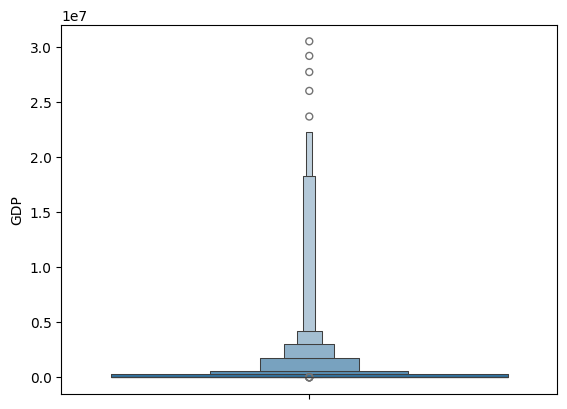

In [8]:
import seaborn as sns
sns.boxenplot(df_long['GDP'])

In [9]:
df_long['Year'].describe()

count    1176.000000
mean     2022.500000
std         1.708552
min      2020.000000
25%      2021.000000
50%      2022.500000
75%      2024.000000
max      2025.000000
Name: Year, dtype: float64

In [10]:
df_long['GDP'].describe()

count    1.176000e+03
mean     5.244051e+05
std      2.360849e+06
min      5.200000e+01
25%      1.196800e+04
50%      4.263850e+04
75%      2.673815e+05
max      3.050722e+07
Name: GDP, dtype: float64

In [11]:
df_long['Z_score'] = df_long.groupby('Country')['GDP'].transform(
    lambda x: (x - x.mean()) / x.std()
)

df_long['Outlier_Z'] = df_long['Z_score'].abs() > 3



In [12]:
df_long['Outlier_Z'].value_counts()

Outlier_Z
False    1176
Name: count, dtype: int64

In [13]:
df_long.head()

,Country,Year,GDP,Z_score,Outlier_Z
0,Afghanistan,2020,20136.0,1.553807,False
196,Afghanistan,2021,14278.0,-1.155585,False
392,Afghanistan,2022,14501.0,-1.052445,False
588,Afghanistan,2023,17248.0,0.218074,False
784,Afghanistan,2024,17248.0,0.218074,False


In [14]:
df_long.drop(columns=['Z_score', 'Outlier_Z'], inplace=True)

In [ ]:
df_long.head(6)

,Country,Year,GDP
0,Afghanistan,2020,20136.0
196,Afghanistan,2021,14278.0
392,Afghanistan,2022,14501.0
588,Afghanistan,2023,17248.0
784,Afghanistan,2024,17248.0
980,Afghanistan,2025,17248.0


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_long['Country'] = le.fit_transform(df_long['Country'])

In [17]:
df_long.sample(10)

,Country,Year,GDP
1134,156,2025,147031.0
67,66,2020,1043.0
839,53,2024,42752.0
334,137,2021,689253.0
321,123,2021,14208.0
370,175,2021,3625.0
206,10,2021,480786.0
991,11,2025,78870.0
409,17,2022,593906.0
1031,49,2025,347342.0


In [18]:
x = df_long[['Country', 'Year']]
y = df_long['GDP']

In [19]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
y = scale.fit_transform(y.values.reshape(-1, 1))

In [20]:
y

array([[0.00065834],
       [0.00046632],
       [0.00047363],
       ...,
       [0.00115029],
       [0.00115291],
       [0.00124954]], shape=(1176, 1))

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [24]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'XGBoost': XGBRegressor()
}


In [25]:
result = {}
for name, model in models.items():
    model.fit(x_train, y_train.ravel())
    y_pred = model.predict(x_test)
    
    mae = mean_absolute_error(y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    r2 = r2_score(y_test,y_pred)
    score = model.score(x_test,y_test)
    print(f"{name}: , MAE = {mae:.3f} , MSE = {mse:.3f} , R2 = {r2:.3f}, Score = {score} ")

Linear Regression: , MAE = 0.027 , MSE = 0.007 , R2 = -0.003, Score = -0.0030146236835901785 
Random Forest: , MAE = 0.003 , MSE = 0.000 , R2 = 0.986, Score = 0.9856710058290798 
Gradient Boosting: , MAE = 0.008 , MSE = 0.000 , R2 = 0.968, Score = 0.9682692947179263 
XGBoost: , MAE = 0.002 , MSE = 0.000 , R2 = 0.997, Score = 0.9972123003241627 


In [26]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

params = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
}

model = xgb.XGBRegressor(random_state=42)

search = RandomizedSearchCV(model, param_distributions=params, 
                            n_iter=20, scoring='r2', cv=5, verbose=1, n_jobs=-1)

search.fit(x_train, y_train.ravel())

print("Best R²:", search.best_score_)
print("Best Params:", search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best R²: 0.9806497023928735
Best Params: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [27]:
model = XGBRegressor(subsample=0.8, reg_lambda=1, reg_alpha=0, n_estimators=500, max_depth=7, learning_rate=0.1, colsample_bytree=0.8)
model.fit(x_train, y_train.ravel())
model.score(x_test, y_test)

0.9977924460512497

In [30]:
model.score(x_train, y_train)

0.985744740120533

In [29]:
model.predict([[0, 2025]],0)

C:\Users\dell\AppData\Roaming\Python\Python313\site-packages\xgboost\core.py:726: FutureWarning: Pass `output_margin` as keyword args.
  warnings.warn(msg, FutureWarning)


array([0.00273145], dtype=float32)

In [31]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import classificationReport
